In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/home/sangyub/Workspace/LAPA/laq')

import torch
from laq_model.latent_action_quantization import LatentActionQuantization

# ckpt_path = '/home/work/open_x_dataset/LAPA/laq/results/codebook_size_32/vae.100000.pt'
# ckpt_path = '/home/work/open_x_dataset/LAPA/laq/results/open_x_checkpoint/laq_openx.pt'
# ckpt_path = '/home/work/open_x_dataset/sangyub/HLAPA/laq/results/sthv2/codebook_8_no_accelerate_config/vae.100000.pt'

# ckpt_path = '/media/hdd/sangyub/output/LAPA/original/vae.90000.pt'
ckpt_path = '/media/hdd/sangyub/output/LAPA/sthv2_1024/vae.100000.pt'


vae = LatentActionQuantization(
    dim = 1024,
    quant_dim = 32,
    codebook_size = 1024,
    image_size = 256,
    patch_size = 32,
    spatial_depth = 8,
    temporal_depth = 8,
    dim_head = 64,
    heads = 16,
    code_seq_len = 4,
).cuda()

# state_dict = torch.load(ckpt_path)
# state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# vae.load_state_dict(state_dict)

vae.load(ckpt_path)

torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])


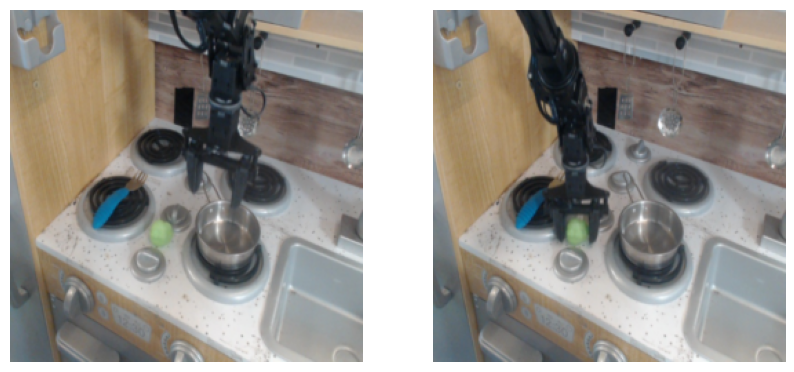

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T

# image_path1 = '/home/work/open_x_dataset/something_v2/20bn-something-something-v2/1/frame_000001.jpg'
image_path1 = '/media/hdd/sangyub/data/raw/bridge_data_v2/datacol1_toykitchen1/many_skills/0/2023-03-15_14-35-28/raw/traj_group0/traj0/images0/im_2.jpg'
image_path2 = '/media/hdd/sangyub/data/raw/bridge_data_v2/datacol1_toykitchen1/many_skills/0/2023-03-15_14-35-28/raw/traj_group0/traj0/images0/im_12.jpg'

# image_path2 = '/home/work/open_x_dataset/something_v2/20bn-something-something-v2/1/frame_000031.jpg'
image1 = Image.open(image_path1)
image2 = Image.open(image_path2)

image_size = (256, 256)
transform = T.Compose([
    T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    T.Resize(image_size),
    T.ToTensor(),
])

transformed_image1 = transform(image1)
transformed_image2 = transform(image2)
transformed_image1 = transformed_image1.unsqueeze(1)
transformed_image2 = transformed_image2.unsqueeze(1)
print(transformed_image1.shape)
print(transformed_image2.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(transformed_image1.squeeze(1).permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(transformed_image2.squeeze(1).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [6]:
import importlib

noise = torch.randn_like(transformed_image1)

video = torch.cat([transformed_image1, transformed_image2], dim=1) 
print(video.shape)

returned_recon = vae.inference(
    video = video.unsqueeze(0).to(device='cuda'), # (b, c, f, h, w)
    step = 0,
    mask = None,
    return_only_codebook_ids=False,
    user_action_token_num=[1,1,3,2],
)

print(returned_recon.shape)

torch.Size([3, 2, 256, 256])
tensor([[1, 1, 3, 2]], device='cuda:0')
torch.Size([1, 3, 256, 256])


In [7]:
a=(vae.vq.codebooks[2])
b=(vae.vq.codebooks[5])

print(torch.cosine_similarity(a, b, dim=0))
# vae.vq.codebooks[2]







tensor(0.8455, device='cuda:0', grad_fn=<SumBackward1>)


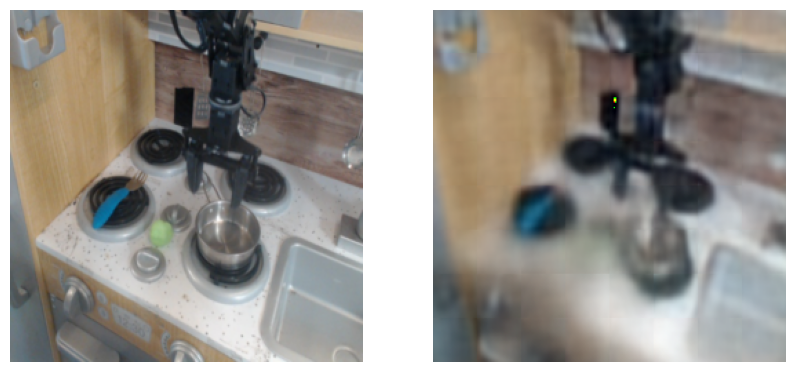

In [8]:
import numpy as np

reconstructed_image = returned_recon.detach().cpu().numpy()
reconstructed_image = np.transpose(reconstructed_image[0], (1, 2, 0))
reconstructed_image = (reconstructed_image * 255).astype(np.uint8)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(transformed_image1.squeeze(1).permute(1, 2, 0))
plt.axis('off')
# plt.subplot(1, 3, 2)
# plt.imshow(transformed_image2.squeeze(1).permute(1, 2, 0))
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()